                In this project,1. need to analyse customer-level data of a leading telecom firm,
                2. build predictive models to identify customers at high risk of churn
                and 3. identify the main indicators of churn.
                ================================================================================
                                              Data Pipeline
                                              =============
    High Value Customer Filtering(HVC)| Target (y) identification | Data Cleaning  | EDA | Feature Engineering | Modelling  


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("telecom_churn_data.csv")

In [4]:
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [6]:
#Derive new features == df["Avg_rech_good_phase"]
#Filter high-value customers ---X is the 70th percentile of the average recharge amount in the first two month
#After tagging churners
#remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names)

In [7]:
df[["total_rech_amt_6","total_rech_amt_7"]].isnull().sum() # Having No Null Values in these two fields

total_rech_amt_6    0
total_rech_amt_7    0
dtype: int64

In [8]:
df["Avg_rech_good_phase"] = round((df["total_rech_amt_6"]+df["total_rech_amt_7"]) /2,2)

In [9]:
np.quantile(df["Avg_rech_good_phase"],0.7)

368.5

In [10]:
df = df[df["Avg_rech_good_phase"]>=np.quantile(df["Avg_rech_good_phase"],0.7)] # HCV -- rows with high value customers

In [11]:
len(df)

30011

In [12]:
df[["total_ic_mou_9","total_og_mou_9","vol_2g_mb_9","vol_3g_mb_9","total_rech_amt_6",
    "total_rech_amt_7","Avg_rech_good_phase","total_rech_amt_8"]][:5]

,total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9,total_rech_amt_6,total_rech_amt_7,Avg_rech_good_phase,total_rech_amt_8
7,0.00,0.00,0.0,0.0,1580,790,1185.0,3638
8,34.91,142.18,0.0,0.0,437,601,519.0,120
13,631.86,446.09,0.0,0.0,507,253,380.0,717
16,334.56,255.74,0.0,0.0,570,348,459.0,160
17,87.13,631.08,0.0,0.0,816,0,408.0,30


In [13]:
df[["total_ic_mou_9","total_og_mou_9","vol_2g_mb_9","vol_3g_mb_9"]].isnull().sum() #Having No Null Values in these fields

total_ic_mou_9    0
total_og_mou_9    0
vol_2g_mb_9       0
vol_3g_mb_9       0
dtype: int64

In [14]:
df["Churn"]=0 # Creating Churn Coulumn (y) and initializing it with 0

In [15]:
df.loc[(df["total_ic_mou_9"]==0)&(df["total_og_mou_9"]==0)&(df["vol_2g_mb_9"]==0)&(df["vol_3g_mb_9"]==0),"Churn"] = 1

In [16]:
round(df["Churn"].value_counts() /len(df)*100,2) # Imbalance Data set Class 0 : 91 % and Class 1 : 9 %

0    91.36
1     8.64
Name: Churn, dtype: float64

In [17]:
sel_cols =[]
for col in df.columns:
    if "_9" not in col:
        sel_cols.append(col)

In [18]:
len(df.columns)-len(sel_cols)

54

In [19]:
df_sel = df[sel_cols] # Dropping data having _9 (9th month Data)

In [20]:
df_sel.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,Avg_rech_good_phase,Churn
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1069.180,1349.850,...,NaN,NaN,NaN,802,57.74,19.38,18.74,0.0,1185.0,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,378.721,492.223,...,NaN,1.0,1.0,315,21.03,910.65,122.16,0.0,519.0,0
13,7002191713,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,492.846,205.671,...,NaN,NaN,1.0,2607,0.00,0.00,0.00,0.0,380.0,0
16,7000875565,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,430.975,299.869,...,NaN,NaN,NaN,511,0.00,2.45,21.89,0.0,459.0,0
17,7000187447,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,690.008,18.980,...,NaN,NaN,NaN,667,0.00,0.00,0.00,0.0,408.0,0


In [21]:
#Data Cleaning -- Checking and dropping columns with > 60 % missing Values on case to case basis

In [22]:
df_drp = round(df_sel.isnull().sum()/len(df) * 100,2)

In [23]:
df_drp = df_drp.reset_index()

In [24]:
df_drp.columns = ["Features","Missing Percentage"]

In [25]:
df_drp[df_drp["Missing Percentage"]>=60]

,Features,Missing Percentage
119,date_of_last_rech_data_6,62.02
120,date_of_last_rech_data_7,61.14
121,date_of_last_rech_data_8,60.83
122,total_rech_data_6,62.02
123,total_rech_data_7,61.14
124,total_rech_data_8,60.83
125,max_rech_data_6,62.02
126,max_rech_data_7,61.14
127,max_rech_data_8,60.83
128,count_rech_2g_6,62.02


In [26]:
df_sel

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,Avg_rech_good_phase,Churn
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1069.180,1349.850,...,NaN,NaN,NaN,802,57.74,19.38,18.74,0.0,1185.0,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,378.721,492.223,...,NaN,1.0,1.0,315,21.03,910.65,122.16,0.0,519.0,0
13,7002191713,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,492.846,205.671,...,NaN,NaN,1.0,2607,0.00,0.00,0.00,0.0,380.0,0
16,7000875565,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,430.975,299.869,...,NaN,NaN,NaN,511,0.00,2.45,21.89,0.0,459.0,0
17,7000187447,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,690.008,18.980,...,NaN,NaN,NaN,667,0.00,0.00,0.00,0.0,408.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99970,7001386760,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,261.269,410.614,...,0.0,0.0,NaN,1022,0.00,0.00,0.00,0.0,392.0,0
99974,7001453306,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.303,321.093,...,NaN,NaN,NaN,3054,0.00,0.00,0.00,0.0,465.0,0
99986,7001729035,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,644.973,455.228,...,1.0,1.0,1.0,2696,497.45,598.67,604.08,0.0,848.5,0
99988,7002111859,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,312.558,512.932,...,NaN,1.0,1.0,328,104.73,0.00,0.00,0.0,467.0,0


In [27]:
df_sel.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'arpu_6', 'arpu_7',
       ...
       'fb_user_6', 'fb_user_7', 'fb_user_8', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g', 'Avg_rech_good_phase',
       'Churn'],
      dtype='object', length=174)

In [28]:
drp_col = list(df_drp[df_drp["Missing Percentage"]>=60]["Features"].values)

In [29]:
len(drp_col)

30

In [30]:
drp_col=['date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8']#Keeping Only 27 columns to drop from all cols having 60% or more missing

In [31]:
len(drp_col)

27

In [32]:
df_sel = df_sel.drop(drp_col,axis=1) # Dropping 27 columns having >= 60% missing data

In [33]:
len(df_sel.columns)

147

In [34]:
df_sel[['total_rech_data_6','total_rech_data_7','total_rech_data_8']].isnull().sum()/len(df_sel)

total_rech_data_6    0.620239
total_rech_data_7    0.611409
total_rech_data_8    0.608344
dtype: float64

In [35]:
df_sel[['total_rech_data_6','total_rech_data_7','total_rech_data_8']].sum() # Filling NA in these columns to 0

total_rech_data_6    28122.0
total_rech_data_7    31628.0
total_rech_data_8    31070.0
dtype: float64

In [36]:
df_sel[['total_rech_data_6','total_rech_data_7','total_rech_data_8']] = df_sel[['total_rech_data_6',
                                                                                'total_rech_data_7','total_rech_data_8']].fillna(0)

In [37]:
df_sel[['total_rech_data_6','total_rech_data_7','total_rech_data_8']].sum()# sanity check after fillinh na =0

total_rech_data_6    28122.0
total_rech_data_7    31628.0
total_rech_data_8    31070.0
dtype: float64

In [38]:
round(df_sel.isnull().sum() / len(df_sel) *100,2)[:51]

mobile_number           0.00
circle_id               0.00
loc_og_t2o_mou          0.38
std_og_t2o_mou          0.38
loc_ic_t2o_mou          0.38
last_date_of_month_6    0.00
last_date_of_month_7    0.10
last_date_of_month_8    0.52
arpu_6                  0.00
arpu_7                  0.00
arpu_8                  0.00
onnet_mou_6             1.05
onnet_mou_7             1.01
onnet_mou_8             3.13
offnet_mou_6            1.05
offnet_mou_7            1.01
offnet_mou_8            3.13
roam_ic_mou_6           1.05
roam_ic_mou_7           1.01
roam_ic_mou_8           3.13
roam_og_mou_6           1.05
roam_og_mou_7           1.01
roam_og_mou_8           3.13
loc_og_t2t_mou_6        1.05
loc_og_t2t_mou_7        1.01
loc_og_t2t_mou_8        3.13
loc_og_t2m_mou_6        1.05
loc_og_t2m_mou_7        1.01
loc_og_t2m_mou_8        3.13
loc_og_t2f_mou_6        1.05
loc_og_t2f_mou_7        1.01
loc_og_t2f_mou_8        3.13
loc_og_t2c_mou_6        1.05
loc_og_t2c_mou_7        1.01
loc_og_t2c_mou

In [39]:
len(df_sel)

30011

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
from sklearn.preprocessing import StandardScaler

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,accuracy_score

In [44]:
from sklearn.linear_model import LogisticRegression

In [45]:
#fpr,tpr,thresholds = roc_curve(y_test_p,lr.decision_function(X_test_p))

In [46]:
#plt.figure(figsize=(8,5))

#plt.plot(fpr,tpr,label="ROC")
#plt.xlabel("FPR = FP / ( FP+TN )")
#plt.ylabel("TPR = TP / ( TP+FN )")
#Find the threshold closest to zero
#close_zero = np.argmin(np.abs(thresholds))
#plt.plot(fpr[close_zero],tpr[close_zero],"o",markersize=10)
#plt.show()

# Data Imputation

In [47]:
len(df_sel)

30011

In [48]:
len(df_sel.columns)

147

In [49]:
df_sel_1 =df_sel.drop(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou','loc_ic_t2o_mou',
                        'last_date_of_month_6','last_date_of_month_7','last_date_of_month_8',
                         'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
                         ,axis=1) # Dropping these 11 columns due to single category or  Date Field

In [50]:
len(df_sel_1.columns)

136

In [51]:
df_sel_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30011 entries, 7 to 99997
Columns: 136 entries, arpu_6 to Churn
dtypes: float64(110), int64(26)
memory usage: 31.4 MB


In [52]:
df_im = round(df_sel_1.isnull().sum()/len(df_sel_1)*100,3)

In [53]:
df_im = df_im.reset_index()

In [54]:
df_im.columns=["Feats","PerMiss"]

In [55]:
icols = df_im[df_im["PerMiss"]>0]["Feats"].values

In [56]:
for col in icols:#Imputing the missing values greater than 0% to 3% with meadian values
    df_sel_1.loc[df_sel_1[col].isnull(),col] =df_sel_1[col].dropna().median()

In [57]:
sum(df_sel_1.isnull().sum())

0

In [58]:
df_sel_1.describe(percentiles=[.25,.50,.75,.90,.95,.99])

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,Avg_rech_good_phase,Churn
count,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,...,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000
mean,587.284404,589.135427,534.857433,297.385708,305.635027,270.922215,420.944380,426.806717,382.877999,17.412764,...,0.137916,0.150212,0.140415,1264.064776,129.439626,135.127102,121.360548,6.562685,696.664356,0.086402
std,442.722413,462.897814,492.259586,460.093114,481.133789,465.019618,468.816296,484.848030,473.303750,79.152657,...,0.875528,0.969286,0.974727,975.263117,390.478591,408.024394,389.726031,48.638658,488.782088,0.280961
min,-2258.709000,-2014.045000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000,368.500000,0.000000
25%,364.161000,365.004500,289.609500,43.510000,43.260000,33.985000,142.825000,141.235000,111.730000,0.000000,...,0.000000,0.000000,0.000000,480.000000,0.000000,0.000000,0.000000,0.000000,450.000000,0.000000
50%,495.682000,493.561000,452.091000,128.330000,127.950000,106.280000,285.960000,285.485000,251.360000,0.000000,...,0.000000,0.000000,0.000000,914.000000,0.000000,0.000000,0.000000,0.000000,568.500000,0.000000
75%,703.922000,700.788000,671.150000,353.310000,359.925000,297.735000,523.125000,532.695000,482.610000,0.000000,...,0.000000,0.000000,0.000000,1924.000000,1.600000,1.990000,0.000000,0.000000,795.500000,0.000000
90%,994.099000,995.557000,985.202000,794.980000,824.380000,723.610000,915.580000,935.690000,853.790000,32.730000,...,0.000000,0.000000,0.000000,2846.000000,438.970000,454.830000,394.500000,0.000000,1118.000000,0.000000
95%,1240.793500,1261.421500,1258.555500,1153.970000,1208.175000,1115.660000,1271.470000,1286.285000,1188.460000,94.585000,...,1.000000,1.000000,1.000000,3179.000000,818.750000,845.315000,761.740000,18.635000,1406.000000,1.000000
99%,1983.089500,1999.374500,1987.934400,2166.370000,2220.367000,2188.504000,2326.290000,2410.104000,2211.642000,349.353000,...,3.000000,3.000000,3.000000,3651.000000,1822.115000,1941.598000,1866.386000,173.662000,2216.300000,1.000000


In [59]:
colk =[] # Getting the coulumns with Kurtosis more than 3 to remove outliers
for col in df_sel_1.columns:
    if col !="Churn":
        if (df_sel_1[col].kurtosis()-3)>0:
            colk.append(col)

In [60]:
len(colk)

128

In [61]:
colk[:5]

['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7']

In [63]:
for col in colk:# Replacing beyond 99% percentile values with 75th percentile of column for columns Kurtosis > 3
    if col !="Churn":
        df_sel_1[col] = df_sel_1[col].mask(df_sel_1[col] > np.quantile(df_sel_1[col],.99),np.quantile(df_sel_1[col],.75))

In [64]:
df_sel_1.describe(percentiles=[.25,.50,.75,.90,.95,.99]) # Describe after replacing beyond 99 percentile with 75th Per

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,Avg_rech_good_phase,Churn
count,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,...,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000
mean,564.601073,566.073762,511.148030,270.524660,277.677303,242.687358,395.060271,399.385755,355.593130,11.299738,...,0.076305,0.073373,0.064943,1264.064776,102.170426,106.583278,93.458603,2.754899,671.519776,0.086402
std,306.334839,308.323397,340.676352,357.416902,371.769150,348.097960,373.259172,379.500624,355.874067,38.618987,...,0.339318,0.334331,0.321424,975.263117,268.663821,283.558395,258.582535,14.686083,311.864295,0.280961
min,-2258.709000,-2014.045000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000,368.500000,0.000000
25%,364.161000,365.004500,289.609500,43.510000,43.260000,33.985000,142.825000,141.235000,111.730000,0.000000,...,0.000000,0.000000,0.000000,480.000000,0.000000,0.000000,0.000000,0.000000,450.000000,0.000000
50%,495.682000,493.561000,452.091000,128.330000,127.950000,106.280000,285.960000,285.485000,251.360000,0.000000,...,0.000000,0.000000,0.000000,914.000000,0.000000,0.000000,0.000000,0.000000,568.500000,0.000000
75%,703.905500,700.787000,671.135000,353.310000,359.917500,297.712500,523.107500,532.662500,482.610000,0.000000,...,0.000000,0.000000,0.000000,1924.000000,1.600000,1.985000,0.000000,0.000000,795.500000,0.000000
90%,962.195000,961.613000,946.050000,744.830000,770.130000,677.940000,867.440000,895.780000,811.610000,27.210000,...,0.000000,0.000000,0.000000,2846.000000,387.480000,398.360000,345.570000,0.000000,1086.000000,0.000000
95%,1173.676500,1189.461500,1189.265000,1066.775000,1096.660000,1007.195000,1167.870000,1185.890000,1096.575000,73.890000,...,1.000000,1.000000,0.000000,3179.000000,707.795000,740.245000,665.510000,10.175000,1317.500000,1.000000
99%,1626.313200,1643.885000,1661.783800,1694.323000,1771.120000,1699.979000,1837.660000,1838.390000,1737.997000,221.174000,...,2.000000,2.000000,2.000000,3651.000000,1342.160000,1445.975000,1337.457000,84.916000,1833.400000,1.000000


In [65]:
#df_sel_1.columns[:51]

In [66]:
#df_sel_1.columns[51:]

In [67]:
len(df_sel_1.columns)

136

In [68]:
len(df_sel_1)

30011

In [69]:
df_sel_1 = df_sel_1.drop(["sep_vbc_3g"],axis=1) # dropping 9th motnh column 

In [70]:
len(df_sel_1.columns)

135

## Ploting each feature for churn = 1 class and not churn = 0 class to spot if distribution of these variables/features differ significantly for these two classes : EDA

Conclusion: Majority of Usage  as well as  Revenue for  Class 1 (Churn Class) is on decrease over 6 to 8  three months period
          : Average Recharge in Good Phase e.g. 6 and 7th month is less for Class 1 (Churn Class)

In [71]:
df_sel_1_0 = df_sel_1[df_sel_1["Churn"]==0]
df_sel_1_1 = df_sel_1[df_sel_1["Churn"]==1]

In [72]:
cola=df_sel_1.columns[:45]
colb=df_sel_1.columns[45:90]
colc=df_sel_1.columns[90:135]

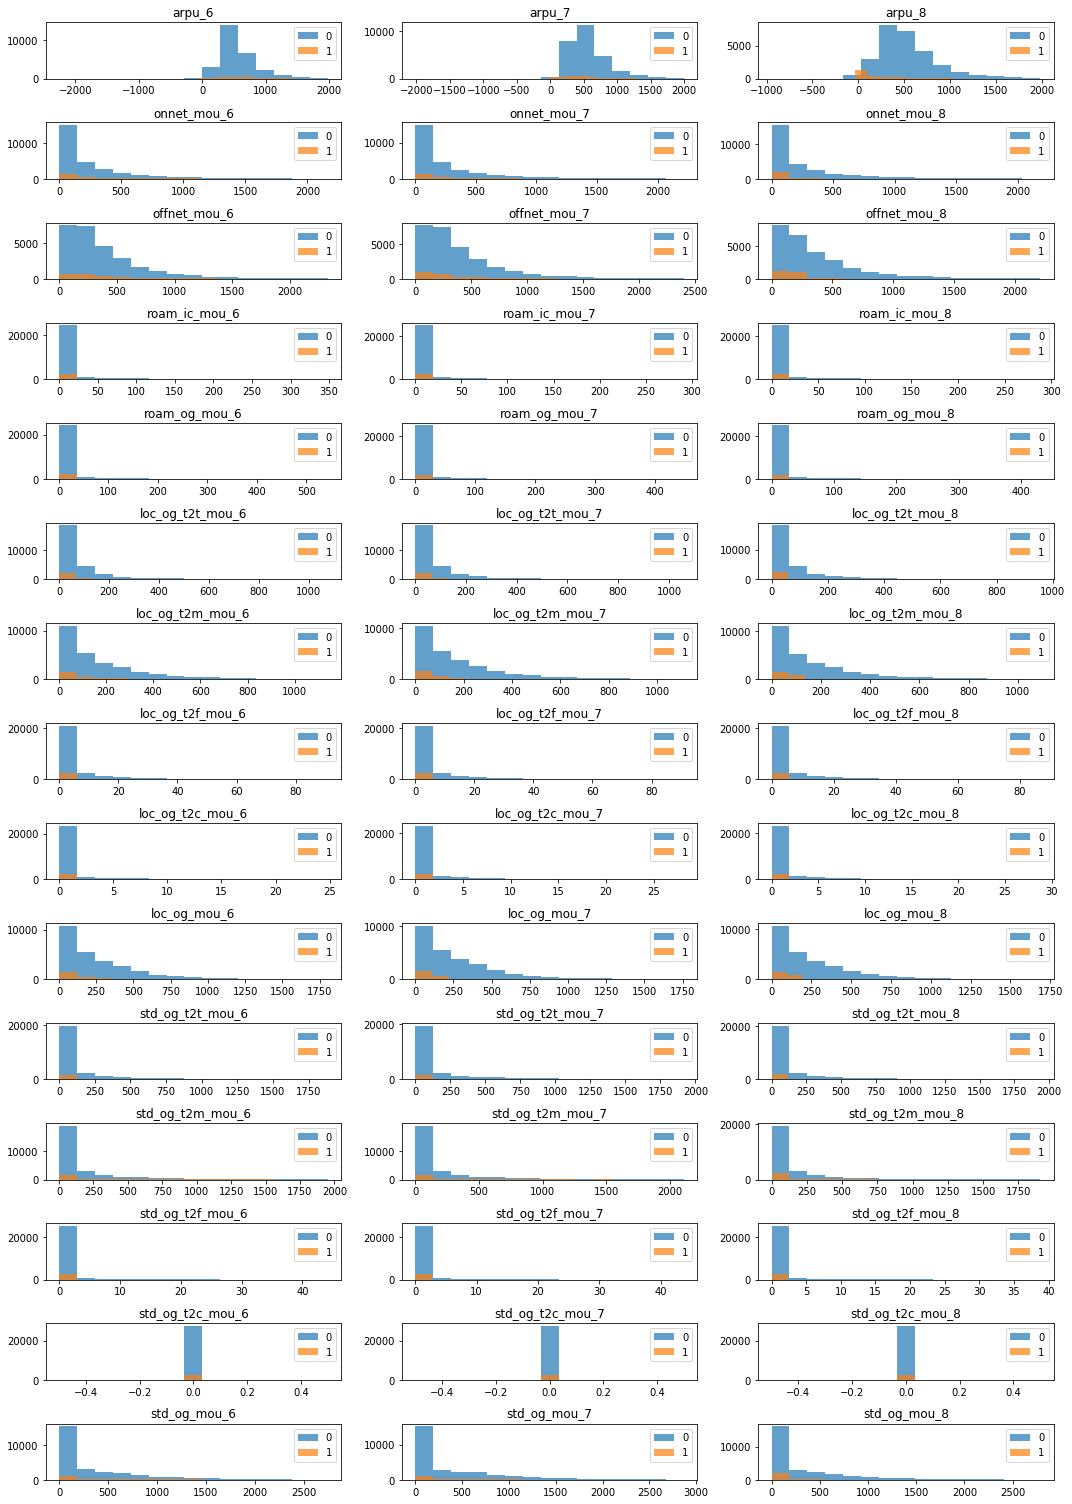

In [73]:
fig,axes = plt.subplots(15,3,figsize=(15,21))
for ax,col in zip(axes.ravel(),cola):
    ax.hist(df_sel_1_0[col],label="0",alpha=0.7,bins=15)
    ax.hist(df_sel_1_1[col],label="1",alpha=0.7,bins=15)
    ax.set_title(col)
    ax.legend(loc="best")
plt.tight_layout()    

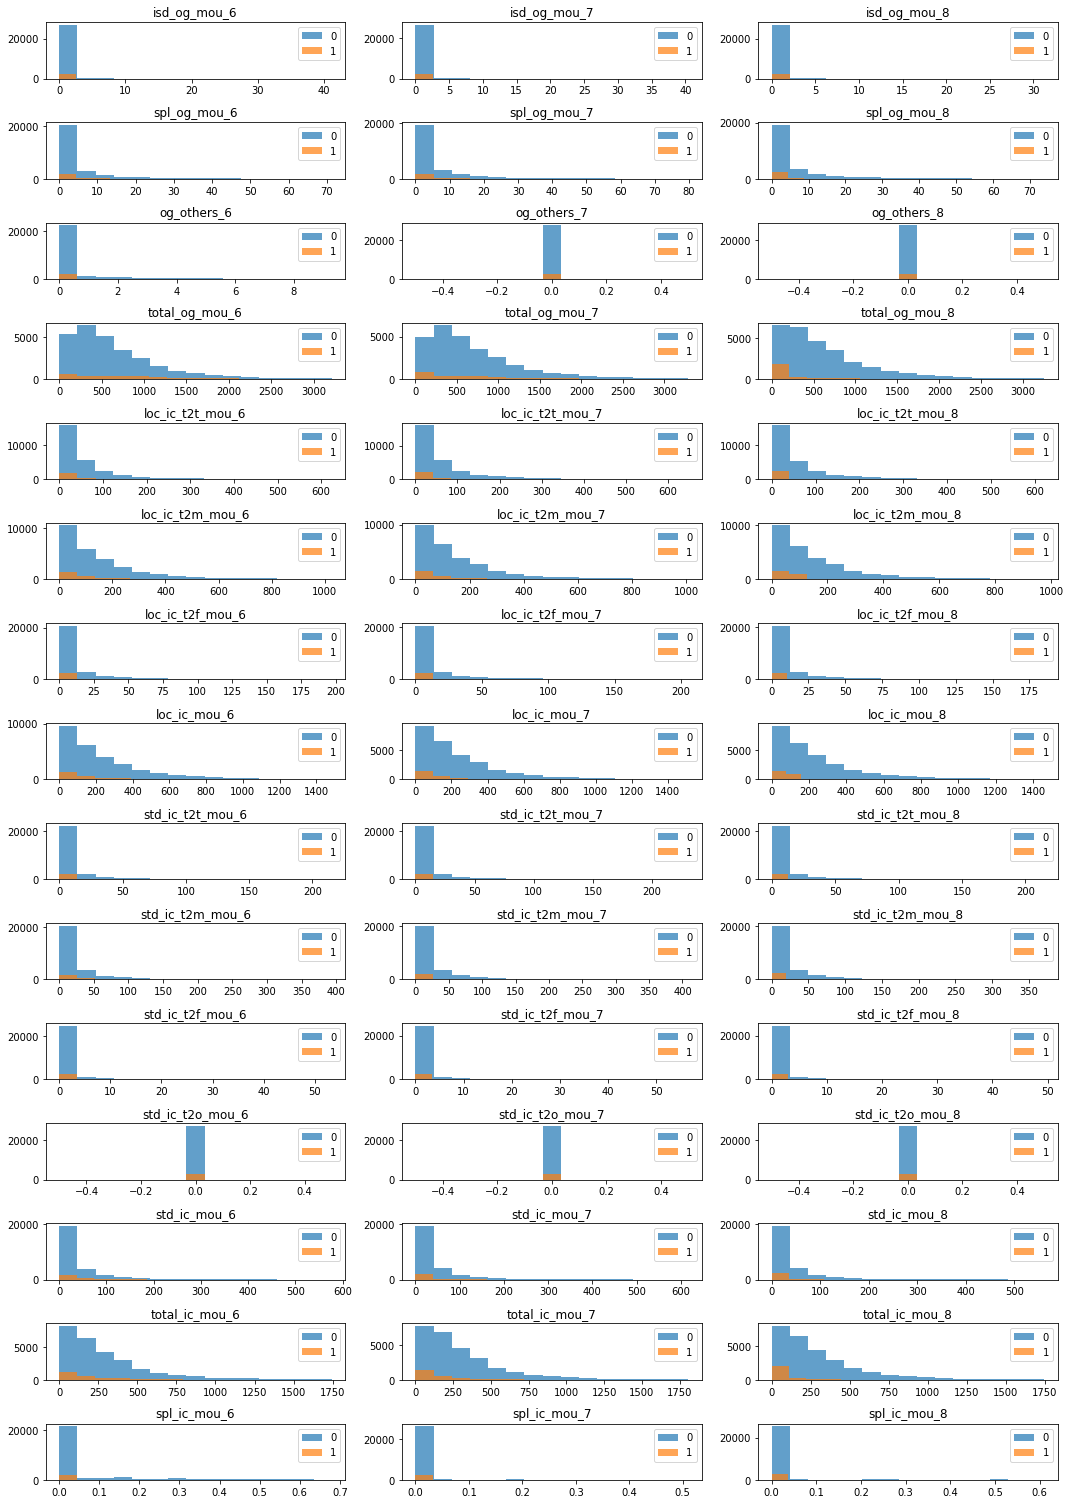

In [74]:
fig,axes = plt.subplots(15,3,figsize=(15,21))
for ax,col in zip(axes.ravel(),colb):
    ax.hist(df_sel_1_0[col],label="0",alpha=0.7,bins=15)
    ax.hist(df_sel_1_1[col],label="1",alpha=0.7,bins=15)
    ax.set_title(col)
    ax.legend(loc="best")
plt.tight_layout() 

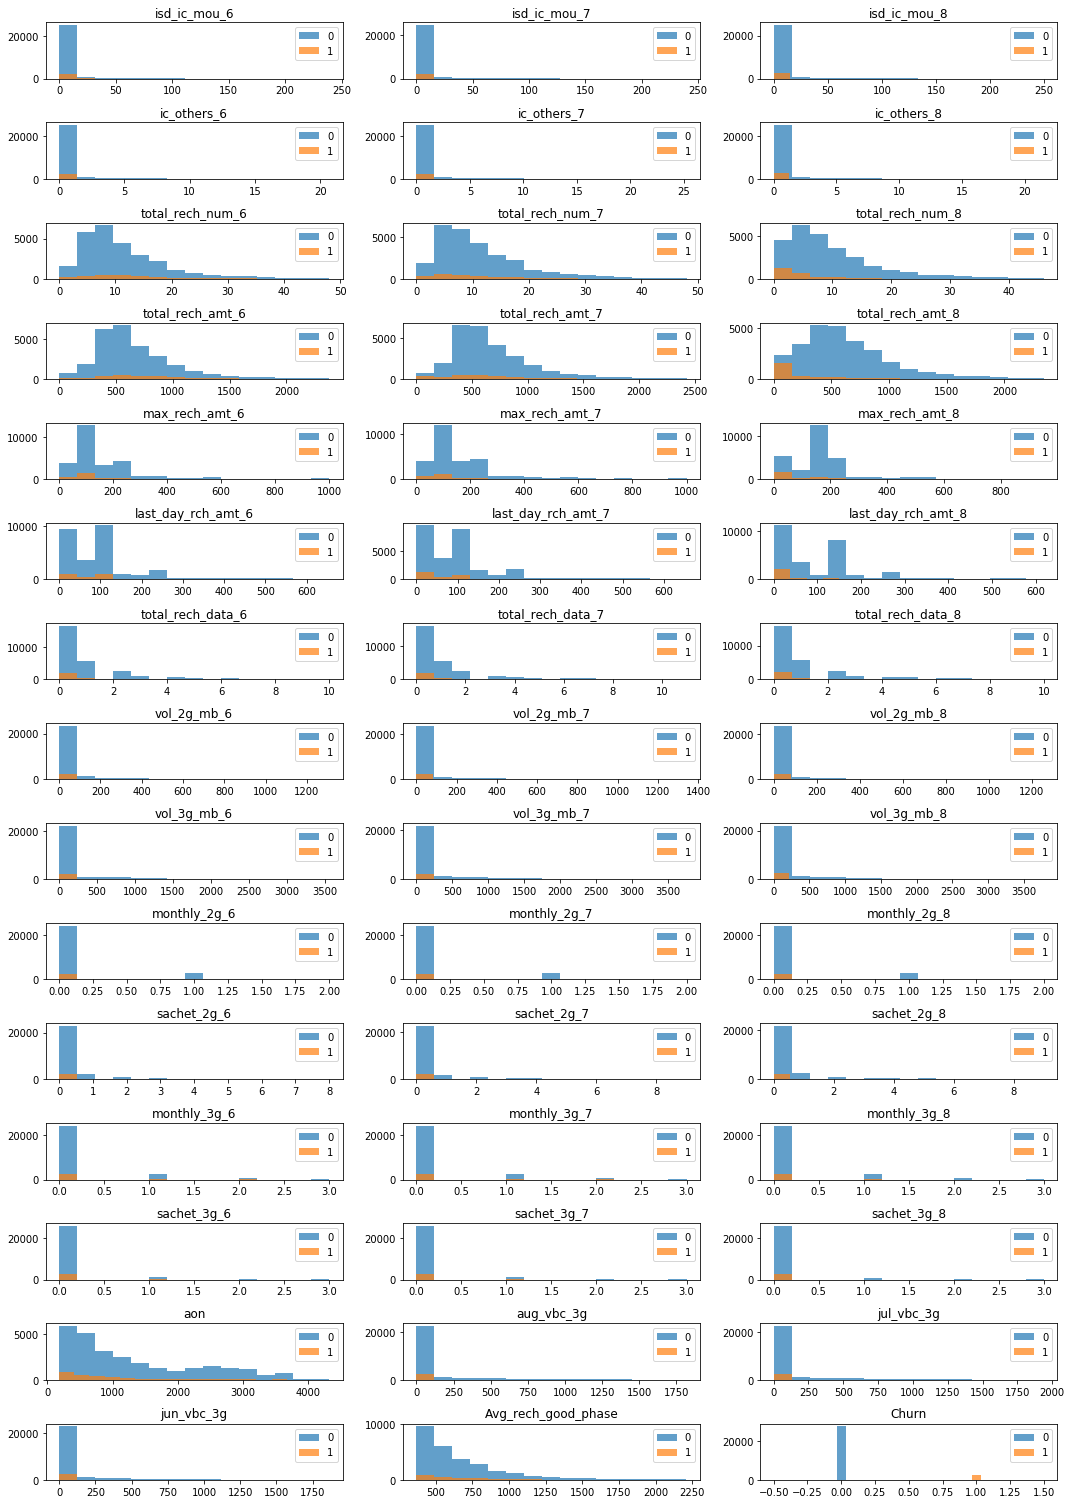

In [75]:
fig,axes = plt.subplots(15,3,figsize=(15,21))
for ax,col in zip(axes.ravel(),colc):
    ax.hist(df_sel_1_0[col],label="0",alpha=0.7,bins=15)
    ax.hist(df_sel_1_1[col],label="1",alpha=0.7,bins=15)
    ax.set_title(col)
    ax.legend(loc="best")
plt.tight_layout()  

In [76]:
# Adding two features Based on Above EDA to track drop of utilization of services provided

In [77]:
# Adding Two Features Based on Above EDA to track drop of utilization of service
df_sel_1["OutGoingUseDrop"] = df_sel_1["total_og_mou_8"]-df_sel_1["total_og_mou_6"] #1 -- Drop in Incoming  Utility 1 drop
df_sel_1["IncomingUseDrop"] = df_sel_1["total_ic_mou_8"]-df_sel_1["total_ic_mou_6"] #2 -- Drop in Outgoing  Utility 2 drop

# 1st Interpretable Model Without PCA--Random Forest

In [78]:
yi = df_sel_1["Churn"]
Xi = df_sel_1.drop(["Churn"],axis=1)

In [79]:
print(Xi.shape,yi.shape)

(30011, 136) (30011,)


In [80]:
X_train, X_test, y_train, y_test = train_test_split(Xi, yi, test_size=0.35, random_state=30)

In [81]:
rf = RandomForestClassifier(n_estimators=200,class_weight={0:.91,1:0.09},criterion="entropy",n_jobs=-1,min_samples_split=4,
                           oob_score=True)

In [82]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.91, 1: 0.09},
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=4, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=None, verbose=0, warm_start=False)

In [83]:
rf.score(X_test,y_test)

0.9404988575780655

In [84]:
print(rf.oob_score_)

0.9402778489772902


In [85]:
confusion_matrix(y_train,rf.predict_proba(X_train)[:,1]>.10) # setting cut off 0.10 from below curve for sensi and specifi
                                                             # values for different probability values

array([[17101,   693],
       [    0,  1713]], dtype=int64)

In [86]:
print(classification_report(y_train,rf.predict_proba(X_train)[:,1]>.10))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     17794
           1       0.71      1.00      0.83      1713

    accuracy                           0.96     19507
   macro avg       0.86      0.98      0.91     19507
weighted avg       0.97      0.96      0.97     19507



In [87]:
confusion_matrix(y_test,rf.predict_proba(X_test)[:,1]>.10)

array([[8412, 1212],
       [ 159,  721]], dtype=int64)

In [88]:
print(classification_report(y_test,rf.predict_proba(X_test)[:,1]>.10)) # Sensitivity Of Minority Class Greater than 70% 
                                                                       # with precision of 50 %

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      9624
           1       0.37      0.82      0.51       880

    accuracy                           0.87     10504
   macro avg       0.68      0.85      0.72     10504
weighted avg       0.93      0.87      0.89     10504



In [89]:
df_rk = pd.DataFrame({"Features":Xi.columns,"Ranking":rf.feature_importances_})

In [91]:
df_rk.sort_values(by="Ranking",ascending=False)[:15] # Top 15 features ranked by Random Forest

,Features,Ranking
86,total_ic_mou_8,0.050105
56,total_og_mou_8,0.044878
2,arpu_8,0.041505
101,total_rech_amt_8,0.030237
107,last_day_rch_amt_8,0.028481
134,OutGoingUseDrop,0.019913
62,loc_ic_t2m_mou_8,0.018721
11,roam_ic_mou_8,0.018563
14,roam_og_mou_8,0.018058
68,loc_ic_mou_8,0.017439


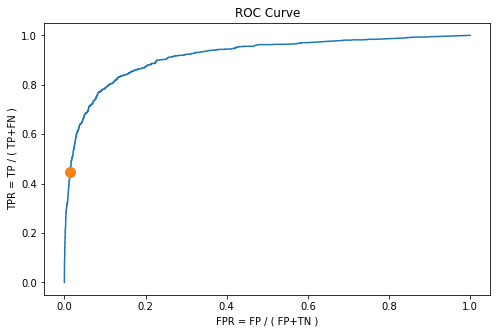

In [92]:
fpr,tpr,thresholds_rf = roc_curve(y_test,rf.predict_proba(X_test)[:,1])
plt.figure(figsize=(8,5))

plt.plot(fpr,tpr,label="ROC RF")
plt.xlabel("FPR = FP / ( FP+TN )")
plt.ylabel("TPR = TP / ( TP+FN )")
#Find the threshold closest to zero
close_zero_rf = np.argmin(np.abs(thresholds_rf-0.5))
plt.plot(fpr[close_zero_rf],tpr[close_zero_rf],"o",markersize=10)
plt.title("ROC Curve")
plt.show()

In [93]:
thresholds_rf[close_zero_rf]

0.4992330244799309

In [94]:
sen0=[]
sen1=[]

for prob in np.linspace(.1,.5,10):
    cf = confusion_matrix(y_train,rf.predict_proba(X_train)[:,1]>prob)
    sensitivity0 = cf[0,0]/(cf[0,0]+cf[0,1])
    sensitivity1= cf[1,1]/(cf[1,1]+cf[1,0])
    sen0.append(sensitivity0)
    sen1.append(sensitivity1)

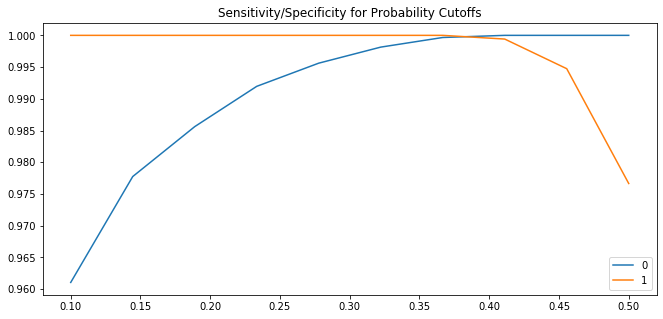

In [95]:
plt.figure(figsize=(11,5))
plt.plot(np.linspace(.1,.5,10),sen0,label="0")
plt.plot(np.linspace(.1,.5,10),sen1,label="1")
plt.legend()
plt.title("Sensitivity/Specificity for Probability Cutoffs")
plt.show()

# 2nd Interpretable Model Without PCA-- Logistic Regression

In [96]:
scaler = StandardScaler()

In [97]:
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

In [98]:
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])

In [99]:
X_train[:3]

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,Avg_rech_good_phase,OutGoingUseDrop,IncomingUseDrop
93427,1.098815,-1.841294,-1.499542,-0.639392,-0.746029,-0.393237,4.605970,-1.043153,-0.292959,-0.260087,...,-0.222207,-0.216155,-0.202292,-1.025762,-0.376364,-0.373741,-0.360012,-0.711156,-3.488841,-0.064280
8407,-0.753892,0.114699,-0.090824,-0.697733,-0.526088,-0.523027,0.299944,2.613041,1.789256,0.094136,...,-0.222207,-0.216155,-0.202292,0.607234,-0.376364,-0.373741,-0.360012,-0.552465,1.159064,0.378732
51706,1.077886,0.806013,1.426641,-0.446283,-0.453435,-0.458922,-0.761275,-0.392938,-0.397555,0.430370,...,-0.222207,-0.216155,-0.202292,0.206417,0.672441,0.835601,0.743020,0.917854,0.268795,1.679007


In [100]:
import statsmodels.api as sm

In [101]:
#Logistic regression model
logml = sm.GLM(y_train,(sm.add_constant(X_train)),family=sm.families.Binomial())
logml.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                19507
Model:                            GLM   Df Residuals:                    19380
Model Family:                Binomial   Df Model:                          126
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3472.6
Date:                Sun, 05 Jul 2020   Deviance:                       6945.3
Time:                        11:57:54   Pearson chi2:                 1.86e+06
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.0432      0.070    -57.624      0.000      -4.181      -3.906
arpu_6                  0.1164      0.077      1.512      0.131      -0.035       0.267
arpu_7                  0.3073      0.080      3.829      0.000       0.150       0.465
arpu_8                 -0.2035      0.112     -1.815      0.070      -0.423       0.016
onnet_mou_6             0.1566      0.072      2.184      0.029       0.016       0.297
onnet_mou_7             0.1556      0.085      1.832      0.067      -0.011       0.322
onnet_mou_8             0.2833      0.097      2.933      0.003       0.094       0.473
offnet_mou_6            0.0327      0.075      0.438      0.661      -0.114       0.179
offnet_mou_7            0.3294      0.091      3.637      0.000       0.152       0.507
offnet_mou_8            0.4394      0.090      4.876      0.000       0.263       0.616
roam_ic_mou_6          -0.0125      0.038     -0.328      0.743      -0.087       0.062
roam_ic_mou_7           0.0071      0.033      0.218      0.827      -0.057       0.071
roam_ic_mou_8           0.0797      0.030      2.642      0.008       0.021       0.139
roam_og_mou_6           0.0095      0.035      0.271      0.786      -0.059       0.079
roam_og_mou_7          -0.0282      0.033     -0.865      0.387      -0.092       0.036
roam_og_mou_8           0.1233      0.029      4.205      0.000       0.066       0.181
loc_og_t2t_mou_6       -0.0228      0.069     -0.332      0.740      -0.158       0.112
loc_og_t2t_mou_7       -0.0257      0.079     -0.323      0.747      -0.181       0.130
loc_og_t2t_mou_8       -0.1800      0.095     -1.891      0.059      -0.367       0.007
loc_og_t2m_mou_6       -0.0868      0.085     -1.026      0.305      -0.253       0.079
loc_og_t2m_mou_7       -0.1558      0.104     -1.497      0.134      -0.360       0.048
loc_og_t2m_mou_8       -0.3583      0.124     -2.882      0.004      -0.602      -0.115
loc_og_t2f_mou_6       -0.0884      0.062     -1.426      0.154      -0.210       0.033
loc_og_t2f_mou_7       -0.1297      0.067     -1.929      0.054      -0.262       0.002
loc_og_t2f_mou_8        0.1042      0.071      1.458      0.145      -0.036       0.244
loc_og_t2c_mou_6        0.0153      0.035      0.437      0.662      -0.053       0.084
loc_og_t2c_mou_7        0.0397      0.037      1.069      0.285      -0.033       0.112
loc_og_t2c_mou_8        0.0170      0.045      0.378      0.706      -0.071       0.105
loc_og_mou_6           -0.0448      0.097     -0.463      0.643      -0.235       0.145
loc_og_mou_7           -0.1564      0.124     -1.258      0.208      -0.400       0.087
loc_og_mou_8            0.5242      0.137      3.815      0.000       0.255       0.794
std_og_t2t_mou_6       -0.0848      0.063     -1.357      0.175      -0.207       0.038
std

In [102]:
logreg = LogisticRegression()

In [103]:
from sklearn.feature_selection import RFE

In [104]:
rfe = RFE(logreg,21)

In [105]:
rfe = rfe.fit(X_train,y_train)

In [106]:
cole = X_train.columns[rfe.support_]

In [107]:
cole

Index(['arpu_7', 'onnet_mou_8', 'offnet_mou_8', 'loc_og_t2m_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_mou_8',
       'total_og_mou_6', 'total_og_mou_8', 'loc_ic_mou_8', 'total_ic_mou_6',
       'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'aon',
       'OutGoingUseDrop', 'IncomingUseDrop'],
      dtype='object')

In [108]:
# Assesing model with statsmodel
X_train_sm= sm.add_constant(X_train[cole])
logm2 = sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res=logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                19507
Model:                            GLM   Df Residuals:                    19487
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3625.1
Date:                Sun, 05 Jul 2020   Deviance:                       7250.1
Time:                        11:59:10   Pearson chi2:                 5.09e+06
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.9816      0.066    -60.033      0.000      -4.112      -3.852
arpu_7                 0.3424      0.035      9.899      0.000       0.275       0.410
onnet_mou_8            0.3948      0.075      5.237      0.000       0.247       0.542
offnet_mou_8           0.5739      0.071      8.130      0.000       0.436       0.712
loc_og_t2m_mou_7      -0.3385      0.053     -6.389      0.000      -0.442      -0.235
std_og_t2t_mou_8      -0.4154      0.077     -5.383      0.000      -0.567      -0.264
std_og_t2m_mou_8      -0.5216      0.069     -7.585      0.000      -0.656      -0.387
std_og_mou_8           0.9510      0.123      7.711      0.000       0.709       1.193
total_og_mou_6        -0.3857      0.046     -8.301      0.000      -0.477      -0.295
total_og_mou_8        -1.0205      0.090    -11.313      0.000      -1.197      -0.844
loc_ic_mou_8           0.9041      0.115      7.882      0.000       0.679       1.129
total_ic_mou_6        -0.7609      0.063    -12.120      0.000      -0.884      -0.638
total_ic_mou_7         0.3054      0.063      4.883      0.000       0.183       0.428
total_ic_mou_8        -1.4218      0.095    -15.001      0.000      -1.608      -1.236
spl_ic_mou_8          -0.4963      0.083     -5.957      0.000      -0.660      -0.333
total_rech_num_8      -0.4828      0.050     -9.657      0.000      -0.581      -0.385
last_day_rch_amt_8    -0.8092      0.057    -14.151      0.000      -0.921      -0.697
vol_2g_mb_8           -0.3923      0.067     -5.890      0.000      -0.523      -0.262
vol_3g_mb_8           -0.5900      0.072     -8.175      0.000      -0.731      -0.449
aon                   -0.3412      0.041     -8.398      0.000      -0.421      -0.262
OutGoingUseDrop       -0.6131      0.048    -12.838      0.000      -0.707      -0.520
IncomingUseDrop       -0.7996      0.050    -16.024      0.000      -0.897      -0.702
======================================================================================
"""

In [109]:
#getting predicted value on train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:11]

93427    0.740149
8407     0.025040
51706    0.000221
47088    0.014308
92996    0.012429
8116     0.000659
57290    0.001344
29585    0.093219
54281    0.036105
89959    0.084032
39832    0.003637
dtype: float64

In [110]:
y_train_pred = y_train_pred.values.reshape(-1)

In [111]:
y_train_pred_final = pd.DataFrame({"Churned":y_train.values,"Churned_Prob":y_train_pred})
y_train_pred_final["CustID"]=y_train.index

In [112]:
y_train_pred_final.head()

,Churned,Churned_Prob,CustID
0,1,0.740149,93427
1,0,0.025040,8407
2,0,0.000221,51706
3,0,0.014308,47088
4,0,0.012429,92996


In [122]:
accuracy_score(y_train_pred_final.Churned,y_train_pred_final.Churned_Prob > 0.09) # Prob cut off based on below curve

0.8310350130722305

In [123]:
confusion_matrix(y_train_pred_final.Churned,y_train_pred_final.Churned_Prob > 0.09)

array([[14793,  3001],
       [  295,  1418]], dtype=int64)

In [124]:
print(classification_report(y_train_pred_final.Churned,y_train_pred_final.Churned_Prob > 0.09))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     17794
           1       0.32      0.83      0.46      1713

    accuracy                           0.83     19507
   macro avg       0.65      0.83      0.68     19507
weighted avg       0.92      0.83      0.86     19507



In [125]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [126]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[cole].columns
vif['VIF'] = [variance_inflation_factor(X_train[cole].values, i) for i in range(X_train[cole].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,total_ic_mou_6,inf
7,total_og_mou_6,inf
19,OutGoingUseDrop,inf
12,total_ic_mou_8,inf
8,total_og_mou_8,inf
20,IncomingUseDrop,inf
6,std_og_mou_8,8.45
4,std_og_t2t_mou_8,5.19
2,offnet_mou_8,5.19
1,onnet_mou_8,5.06


In [131]:
# Assesing model with statsmodel after dropping 7 columns with high VIF =inf value and One p value >0.05
p05=["IncomingUseDrop","total_ic_mou_8","OutGoingUseDrop","total_og_mou_6","total_og_mou_8","total_ic_mou_6"]
X_train_sm= sm.add_constant(X_train[cole].drop(p05,axis=1))
logm3 = sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res=logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                19507
Model:                            GLM   Df Residuals:                    19491
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4049.1
Date:                Sun, 05 Jul 2020   Deviance:                       8098.3
Time:                        12:09:19   Pearson chi2:                 1.15e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.7542      0.061    -61.168      0.000      -3.874      -3.634
arpu_7                 0.3067      0.032      9.561      0.000       0.244       0.370
onnet_mou_8            0.1381      0.060      2.309      0.021       0.021       0.255
offnet_mou_8           0.4249      0.058      7.294      0.000       0.311       0.539
loc_og_t2m_mou_7      -0.4480      0.050     -9.011      0.000      -0.545      -0.351
std_og_t2t_mou_8      -0.4436      0.072     -6.154      0.000      -0.585      -0.302
std_og_t2m_mou_8      -0.6773      0.068     -9.999      0.000      -0.810      -0.545
std_og_mou_8          -0.0647      0.072     -0.904      0.366      -0.205       0.076
loc_ic_mou_8          -0.9443      0.076    -12.484      0.000      -1.093      -0.796
total_ic_mou_7         0.0530      0.046      1.159      0.246      -0.037       0.142
spl_ic_mou_8          -0.5836      0.085     -6.838      0.000      -0.751      -0.416
total_rech_num_8      -0.8890      0.051    -17.431      0.000      -0.989      -0.789
last_day_rch_amt_8    -1.1404      0.056    -20.192      0.000      -1.251      -1.030
vol_2g_mb_8           -0.4369      0.068     -6.462      0.000      -0.569      -0.304
vol_3g_mb_8           -0.7137      0.076     -9.346      0.000      -0.863      -0.564
aon                   -0.4597      0.038    -12.099      0.000      -0.534      -0.385
======================================================================================
"""

In [132]:
#getting predicted value on train set
y_train_pred = res.predict(X_train_sm)
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:11]

array([0.37224951, 0.01947607, 0.00300468, 0.01516208, 0.00639091,
       0.01089225, 0.03660646, 0.05108197, 0.06539288, 0.14768605,
       0.00676394])

In [133]:
y_train_pred_final = pd.DataFrame({"Churned":y_train.values,"Churned_Prob":y_train_pred})
y_train_pred_final["CustID"]=y_train.index
y_train_pred_final["predicted"] = y_train_pred_final["Churned_Prob"].map(lambda x: 1 if x > 0.09 else 0)


In [134]:
y_train_pred_final.head()

,Churned,Churned_Prob,CustID,predicted
0,1,0.372250,93427,1
1,0,0.019476,8407,0
2,0,0.003005,51706,0
3,0,0.015162,47088,0
4,0,0.006391,92996,0


In [135]:
confusion_matrix(y_train_pred_final.Churned,y_train_pred_final.predicted)

array([[14096,  3698],
       [  312,  1401]], dtype=int64)

In [136]:
print(classification_report(y_train_pred_final.Churned,y_train_pred_final.predicted))

              precision    recall  f1-score   support

           0       0.98      0.79      0.88     17794
           1       0.27      0.82      0.41      1713

    accuracy                           0.79     19507
   macro avg       0.63      0.81      0.64     19507
weighted avg       0.92      0.79      0.83     19507



In [137]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
# No dropping of further columns to avoid drop in accuracy due to imbalanced data set despite of VIF > 3
vif = pd.DataFrame()
vif['Features'] = X_train[cole].drop(p05,axis=1).columns
vif['VIF'] = [variance_inflation_factor(X_train[cole].drop(p05,axis=1).values, i) for i in range(X_train[cole].drop(p05,axis=1).shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
6,std_og_mou_8,5.44
4,std_og_t2t_mou_8,4.70
5,std_og_t2m_mou_8,4.48
2,offnet_mou_8,4.00
1,onnet_mou_8,3.51
7,loc_ic_mou_8,2.39
8,total_ic_mou_7,2.12
3,loc_og_t2m_mou_7,1.95
0,arpu_7,1.41
10,total_rech_num_8,1.32


In [138]:
colf = X_train[cole].drop(p05,axis=1).columns

In [139]:
colf

Index(['arpu_7', 'onnet_mou_8', 'offnet_mou_8', 'loc_og_t2m_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_mou_8', 'loc_ic_mou_8',
       'total_ic_mou_7', 'spl_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'aon'],
      dtype='object')

In [140]:
colg = ['arpu_7', 'onnet_mou_8', 'offnet_mou_8', 'loc_og_t2m_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_mou_8', 'loc_ic_mou_8',
        'spl_ic_mou_8', 'total_rech_num_8',
       'last_day_rch_amt_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'aon']

In [141]:
# Assesing model with statsmodel after dropping 1 column with high VIF = 5.44 value and 1 for p values >0.05

X_train_sm= sm.add_constant(X_train[colg])
logm4 = sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res=logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                19507
Model:                            GLM   Df Residuals:                    19492
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4049.8
Date:                Sun, 05 Jul 2020   Deviance:                       8099.6
Time:                        12:16:34   Pearson chi2:                 1.14e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.7519      0.061    -61.197      0.000      -3.872      -3.632
arpu_7                 0.3141      0.031      9.999      0.000       0.253       0.376
onnet_mou_8            0.1344      0.060      2.247      0.025       0.017       0.252
offnet_mou_8           0.4146      0.058      7.185      0.000       0.301       0.528
loc_og_t2m_mou_7      -0.4347      0.048     -9.022      0.000      -0.529      -0.340
std_og_t2t_mou_8      -0.4439      0.072     -6.158      0.000      -0.585      -0.303
std_og_t2m_mou_8      -0.6708      0.068     -9.935      0.000      -0.803      -0.538
std_og_mou_8          -0.0624      0.071     -0.874      0.382      -0.202       0.078
loc_ic_mou_8          -0.9096      0.069    -13.117      0.000      -1.046      -0.774
spl_ic_mou_8          -0.5841      0.085     -6.841      0.000      -0.751      -0.417
total_rech_num_8      -0.8884      0.051    -17.432      0.000      -0.988      -0.789
last_day_rch_amt_8    -1.1397      0.056    -20.181      0.000      -1.250      -1.029
vol_2g_mb_8           -0.4365      0.068     -6.461      0.000      -0.569      -0.304
vol_3g_mb_8           -0.7152      0.076     -9.368      0.000      -0.865      -0.566
aon                   -0.4588      0.038    -12.081      0.000      -0.533      -0.384
======================================================================================
"""

In [142]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[colg].columns
vif['VIF'] = [variance_inflation_factor(X_train[colg].values, i) for i in range(X_train[colg].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
6,std_og_mou_8,5.44
4,std_og_t2t_mou_8,4.70
5,std_og_t2m_mou_8,4.46
2,offnet_mou_8,3.95
1,onnet_mou_8,3.51
3,loc_og_t2m_mou_7,1.89
7,loc_ic_mou_8,1.49
0,arpu_7,1.38
9,total_rech_num_8,1.31
10,last_day_rch_amt_8,1.20


In [144]:
colh =['arpu_7',
 'onnet_mou_8',
 'offnet_mou_8',
 'loc_og_t2m_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'loc_ic_mou_8',
 'spl_ic_mou_8',
 'total_rech_num_8',
 'last_day_rch_amt_8',
 'vol_2g_mb_8',
 'vol_3g_mb_8',
 'aon']

In [145]:
#Assesing model with statsmodel after dropping 1 columns with high VIF = 4.25 value and One p value >0.05

X_train_sm= sm.add_constant(X_train[colh])
logm5 = sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res=logm5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                19507
Model:                            GLM   Df Residuals:                    19493
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4050.2
Date:                Sun, 05 Jul 2020   Deviance:                       8100.4
Time:                        12:19:04   Pearson chi2:                 1.13e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.7517      0.061    -61.208      0.000      -3.872      -3.632
arpu_7                 0.3113      0.031      9.964      0.000       0.250       0.373
onnet_mou_8            0.1212      0.058      2.100      0.036       0.008       0.234
offnet_mou_8           0.3957      0.054      7.374      0.000       0.291       0.501
loc_og_t2m_mou_7      -0.4272      0.047     -9.017      0.000      -0.520      -0.334
std_og_t2t_mou_8      -0.4692      0.066     -7.158      0.000      -0.598      -0.341
std_og_t2m_mou_8      -0.6914      0.063    -10.932      0.000      -0.815      -0.567
loc_ic_mou_8          -0.9023      0.069    -13.114      0.000      -1.037      -0.767
spl_ic_mou_8          -0.5857      0.085     -6.852      0.000      -0.753      -0.418
total_rech_num_8      -0.8925      0.051    -17.561      0.000      -0.992      -0.793
last_day_rch_amt_8    -1.1392      0.056    -20.171      0.000      -1.250      -1.028
vol_2g_mb_8           -0.4344      0.067     -6.444      0.000      -0.567      -0.302
vol_3g_mb_8           -0.7135      0.076     -9.355      0.000      -0.863      -0.564
aon                   -0.4581      0.038    -12.065      0.000      -0.532      -0.384
======================================================================================
"""

In [146]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[colh].columns
vif['VIF'] = [variance_inflation_factor(X_train[colh].values, i) for i in range(X_train[colh].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,offnet_mou_8,3.85
4,std_og_t2t_mou_8,3.49
1,onnet_mou_8,3.43
5,std_og_t2m_mou_8,3.39
3,loc_og_t2m_mou_7,1.85
6,loc_ic_mou_8,1.48
0,arpu_7,1.35
8,total_rech_num_8,1.31
9,last_day_rch_amt_8,1.20
12,aon,1.14


In [148]:
coli =['arpu_7',
 'onnet_mou_8',
 'loc_og_t2m_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'loc_ic_mou_8',
 'spl_ic_mou_8',
 'total_rech_num_8',
 'last_day_rch_amt_8',
 'vol_2g_mb_8',
 'vol_3g_mb_8',
 'aon']

In [149]:
#Assesing model with statsmodel after dropping 1 columns with high VIF = 4.25 value and One p value >0.05

X_train_sm= sm.add_constant(X_train[coli])
logm6 = sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res=logm6.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                19507
Model:                            GLM   Df Residuals:                    19494
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4073.7
Date:                Sun, 05 Jul 2020   Deviance:                       8147.3
Time:                        12:20:26   Pearson chi2:                 9.79e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.7232      0.060    -61.556      0.000      -3.842      -3.605
arpu_7                 0.3417      0.031     10.970      0.000       0.281       0.403
onnet_mou_8            0.1262      0.056      2.250      0.024       0.016       0.236
loc_og_t2m_mou_7      -0.3504      0.046     -7.602      0.000      -0.441      -0.260
std_og_t2t_mou_8      -0.5002      0.064     -7.776      0.000      -0.626      -0.374
std_og_t2m_mou_8      -0.3841      0.048     -8.076      0.000      -0.477      -0.291
loc_ic_mou_8          -0.7978      0.065    -12.197      0.000      -0.926      -0.670
spl_ic_mou_8          -0.5925      0.085     -6.933      0.000      -0.760      -0.425
total_rech_num_8      -0.8556      0.050    -17.001      0.000      -0.954      -0.757
last_day_rch_amt_8    -1.1007      0.056    -19.727      0.000      -1.210      -0.991
vol_2g_mb_8           -0.4461      0.068     -6.594      0.000      -0.579      -0.313
vol_3g_mb_8           -0.7331      0.077     -9.575      0.000      -0.883      -0.583
aon                   -0.4575      0.038    -12.071      0.000      -0.532      -0.383
======================================================================================
"""

In [150]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[coli].columns
vif['VIF'] = [variance_inflation_factor(X_train[coli].values, i) for i in range(X_train[coli].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,std_og_t2t_mou_8,3.47
1,onnet_mou_8,3.43
2,loc_og_t2m_mou_7,1.47
5,loc_ic_mou_8,1.43
0,arpu_7,1.33
7,total_rech_num_8,1.29
4,std_og_t2m_mou_8,1.19
8,last_day_rch_amt_8,1.18
11,aon,1.14
10,vol_3g_mb_8,1.09


In [152]:
colj =['arpu_7',
 'onnet_mou_8',
 'loc_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'loc_ic_mou_8',
 'spl_ic_mou_8',
 'total_rech_num_8',
 'last_day_rch_amt_8',
 'vol_2g_mb_8',
 'vol_3g_mb_8',
 'aon']

In [153]:
#Assesing model with statsmodel after dropping 1 columns with high VIF = 4.25 value and One p value >0.05
X_train_sm= sm.add_constant(X_train[colj])
logm7 = sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res=logm7.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                19507
Model:                            GLM   Df Residuals:                    19495
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4100.4
Date:                Sun, 05 Jul 2020   Deviance:                       8200.8
Time:                        12:21:35   Pearson chi2:                 4.95e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.7024      0.060    -61.655      0.000      -3.820      -3.585
arpu_7                 0.3439      0.031     11.028      0.000       0.283       0.405
onnet_mou_8           -0.2692      0.042     -6.354      0.000      -0.352      -0.186
loc_og_t2m_mou_7      -0.3362      0.046     -7.310      0.000      -0.426      -0.246
std_og_t2m_mou_8      -0.4090      0.048     -8.486      0.000      -0.503      -0.315
loc_ic_mou_8          -0.7173      0.064    -11.225      0.000      -0.843      -0.592
spl_ic_mou_8          -0.5964      0.086     -6.973      0.000      -0.764      -0.429
total_rech_num_8      -0.8811      0.050    -17.452      0.000      -0.980      -0.782
last_day_rch_amt_8    -1.1004      0.056    -19.718      0.000      -1.210      -0.991
vol_2g_mb_8           -0.4406      0.067     -6.547      0.000      -0.572      -0.309
vol_3g_mb_8           -0.7256      0.076     -9.526      0.000      -0.875      -0.576
aon                   -0.4530      0.038    -11.964      0.000      -0.527      -0.379
======================================================================================
"""

In [154]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[colj].columns
vif['VIF'] = [variance_inflation_factor(X_train[colj].values, i) for i in range(X_train[colj].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,loc_og_t2m_mou_7,1.46
4,loc_ic_mou_8,1.38
0,arpu_7,1.33
6,total_rech_num_8,1.29
3,std_og_t2m_mou_8,1.18
7,last_day_rch_amt_8,1.18
1,onnet_mou_8,1.16
10,aon,1.14
9,vol_3g_mb_8,1.09
5,spl_ic_mou_8,1.03


In [155]:
#getting predicted value on train set
y_train_pred = res.predict(X_train_sm)
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:11]

array([0.31748597, 0.02124264, 0.00453898, 0.01331307, 0.01025757,
       0.01461156, 0.00979905, 0.06422327, 0.06588393, 0.18718877,
       0.0075791 ])

In [156]:
y_train_pred_final.head()

,Churned,Churned_Prob,CustID,predicted
0,1,0.372250,93427,1
1,0,0.019476,8407,0
2,0,0.003005,51706,0
3,0,0.015162,47088,0
4,0,0.006391,92996,0


In [157]:
confusion_matrix(y_train_pred_final.Churned,y_train_pred_final.predicted)

array([[14096,  3698],
       [  312,  1401]], dtype=int64)

In [158]:
print(classification_report(y_train_pred_final.Churned,y_train_pred_final.predicted))

              precision    recall  f1-score   support

           0       0.98      0.79      0.88     17794
           1       0.27      0.82      0.41      1713

    accuracy                           0.79     19507
   macro avg       0.63      0.81      0.64     19507
weighted avg       0.92      0.79      0.83     19507



In [159]:
# Fixing the threshold probability for best sensitivity and specificity
from sklearn.metrics import roc_curve,roc_auc_score

In [160]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [161]:
fpr, tpr, thresholds = roc_curve( y_train_pred_final.Churned, y_train_pred_final.Churned_Prob,
                                 drop_intermediate = False )

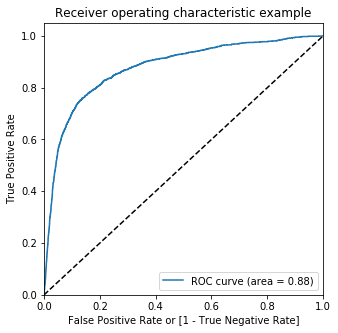

In [162]:
draw_roc(y_train_pred_final.Churned, y_train_pred_final.Churned_Prob)

In [163]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churned_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churned,Churned_Prob,CustID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.372250,93427,1,1,1,1,1,0,0,0,0,0,0
1,0,0.019476,8407,0,1,0,0,0,0,0,0,0,0,0
2,0,0.003005,51706,0,1,0,0,0,0,0,0,0,0,0
3,0,0.015162,47088,0,1,0,0,0,0,0,0,0,0,0
4,0,0.006391,92996,0,1,0,0,0,0,0,0,0,0,0


In [164]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_train_pred_final.Churned, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.087815  1.000000  0.000000
0.1   0.1  0.809504  0.803269  0.810105
0.2   0.2  0.887220  0.683012  0.906879
0.3   0.3  0.913569  0.577350  0.945937
0.4   0.4  0.919414  0.386457  0.970720
0.5   0.5  0.917158  0.189142  0.987243
0.6   0.6  0.913057  0.048453  0.996291
0.7   0.7  0.912390  0.010508  0.999213
0.8   0.8  0.912185  0.001751  0.999831
0.9   0.9  0.912185  0.000000  1.000000


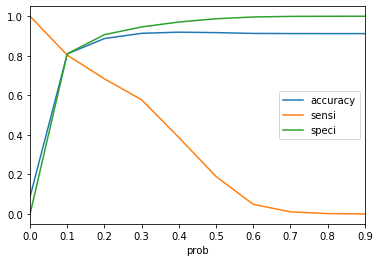

In [165]:
# Let's plot accuracy sensitivity and specificity for various probabilities
#Zero in at the cutoff probability of 0.09 for 80% sensitivity and specificity
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [166]:
dfc = pd.read_html(res.summary().tables[1].as_html(),header=0,index_col=0)[0]

In [167]:
Model = dfc["coef"]

In [168]:
Model.sort_values(ascending=False) ##Final Model with coefficient

arpu_7                0.3439
onnet_mou_8          -0.2692
loc_og_t2m_mou_7     -0.3362
std_og_t2m_mou_8     -0.4090
vol_2g_mb_8          -0.4406
aon                  -0.4530
spl_ic_mou_8         -0.5964
loc_ic_mou_8         -0.7173
vol_3g_mb_8          -0.7256
total_rech_num_8     -0.8811
last_day_rch_amt_8   -1.1004
const                -3.7024
Name: coef, dtype: float64

In [169]:
colt = X_train[colj].columns

In [170]:
X_test = X_test[colt] # selecting final columns for prediction

In [171]:
# Assesing model on test set
X_test_sm= sm.add_constant(X_test)

In [172]:
#getting predicted value on train set
y_test_pred = res.predict(X_test_sm)
y_test_pred = y_test_pred.values.reshape(-1)
y_test_pred[:11]

array([0.03943885, 0.00084414, 0.09344668, 0.18164992, 0.08595974,
       0.00824697, 0.00186949, 0.00161101, 0.00165389, 0.20035883,
       0.02383092])

In [173]:
y_test_pred_final = pd.DataFrame({"Churned":y_test.values,"Churned_Prob":y_test_pred})
y_test_pred_final["CustID"]=y_test.index
y_test_pred_final["predicted"] = y_test_pred_final["Churned_Prob"].map(lambda x: 1 if x > 0.09 else 0)

In [174]:
y_test_pred_final.head()

,Churned,Churned_Prob,CustID,predicted
0,0,0.039439,15306,0
1,0,0.000844,37949,0
2,0,0.093447,26657,1
3,0,0.181650,21558,1
4,0,0.085960,30852,0


In [175]:
confusion_matrix(y_test_pred_final.Churned,y_test_pred_final.predicted) #Prediction on Test data

array([[7543, 2081],
       [ 175,  705]], dtype=int64)

In [176]:
print(classification_report(y_test_pred_final.Churned,y_test_pred_final.predicted)) # Sensitivity and Specificity on test

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      9624
           1       0.25      0.80      0.38       880

    accuracy                           0.79     10504
   macro avg       0.62      0.79      0.63     10504
weighted avg       0.92      0.79      0.83     10504



In [179]:
Model.sort_values(ascending=False) ##Final Model with 11 interpretable features and co efficients

arpu_7                0.3439
onnet_mou_8          -0.2692
loc_og_t2m_mou_7     -0.3362
std_og_t2m_mou_8     -0.4090
vol_2g_mb_8          -0.4406
aon                  -0.4530
spl_ic_mou_8         -0.5964
loc_ic_mou_8         -0.7173
vol_3g_mb_8          -0.7256
total_rech_num_8     -0.8811
last_day_rch_amt_8   -1.1004
const                -3.7024
Name: coef, dtype: float64

# PCA based Models -- For Predictability

In [188]:
sns.set()

In [339]:
y = df_sel_1["Churn"]
X = df_sel_1.drop(["Churn"],axis=1)

In [340]:
print(X.shape,y.shape)

(30011, 136) (30011,)


In [341]:
from sklearn.decomposition import PCA

In [342]:
pca = PCA().fit(X)

Text(0, 0.5, 'Cumulative Explained Variance')

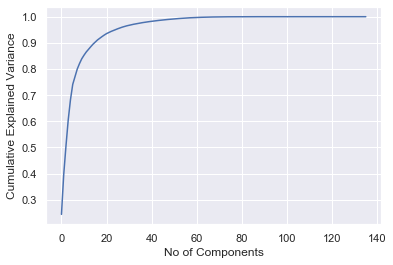

In [343]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))# We Keep 20 Components to explain more than 90% variance
plt.xlabel("No of Components")
plt.ylabel("Cumulative Explained Variance")

In [344]:
pca20 = PCA(n_components=20)

In [345]:
Xp = pca.fit_transform(X)

In [346]:
from sklearn.model_selection import train_test_split

In [347]:
 X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size=0.33, random_state=42)

In [348]:
from sklearn.preprocessing import StandardScaler

In [ ]:
#Scaling before PCA is increasing the no of components needed to explain variance to 80 and
#Scaling after PCA is reducing overll accuray at cost of increase in sensitivity of class 1 so avoided scaling

In [323]:
sc = StandardScaler()

In [349]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [350]:
from sklearn.linear_model import LogisticRegression

In [351]:
lr = LogisticRegression(class_weight={0:.91,1:.09})

In [352]:
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight={0: 0.91, 1: 0.09}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [353]:
lr.score(X_test,y_test)

0.9155896607431341

In [354]:
confusion_matrix(y_test,lr.predict(X_test))

array([[9051,    6],
       [ 830,   17]], dtype=int64)

In [355]:
print(classification_report(y_test,lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      9057
           1       0.74      0.02      0.04       847

    accuracy                           0.92      9904
   macro avg       0.83      0.51      0.50      9904
weighted avg       0.90      0.92      0.88      9904



In [356]:
fpr,tpr,thresholds = roc_curve(y_test,lr.decision_function(X_test))

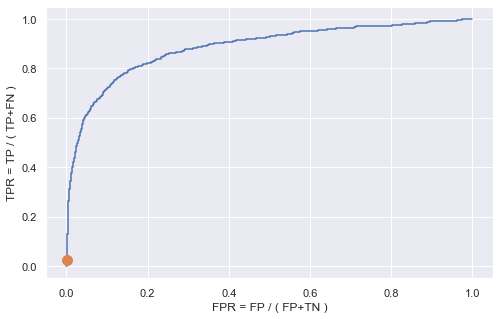

In [357]:
plt.figure(figsize=(8,5))

plt.plot(fpr,tpr,label="ROC")
plt.xlabel("FPR = FP / ( FP+TN )")
plt.ylabel("TPR = TP / ( TP+FN )")
#Find the threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero],tpr[close_zero],"o",markersize=10)
plt.show()

In [414]:
sen0=[]
sen1=[]
accu =[]
for prob in np.linspace(.001,.1,15):
    cf = confusion_matrix(y_train,lr.predict_proba(X_train)[:,1]>prob)
    sensitivity0 = cf[0,0]/(cf[0,0]+cf[0,1])
    sensitivity1= cf[1,1]/(cf[1,1]+cf[1,0])
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,1]+cf[1,0])
    sen0.append(sensitivity0)
    sen1.append(sensitivity1)
    accu.append(acc)

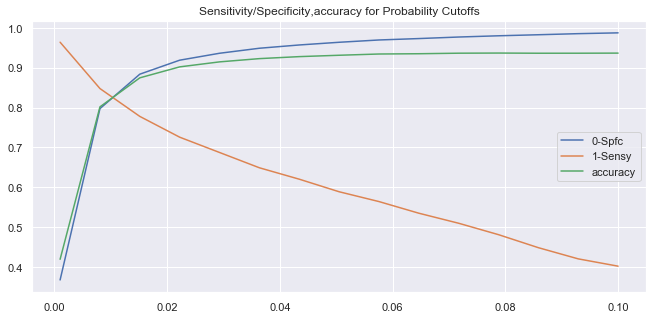

In [415]:
plt.figure(figsize=(11,5))
plt.plot(np.linspace(.001,.1,15),sen0,label="0-Spfc")
plt.plot(np.linspace(.001,.1,15),sen1,label="1-Sensy")
plt.plot(np.linspace(.001,.1,15),accu,label="accuracy")
plt.legend()
plt.title("Sensitivity/Specificity,accuracy for Probability Cutoffs")
plt.show()

In [428]:
confusion_matrix(y_train,lr.predict_proba(X_train)[:,1] > 0.013)

array([[15912,  2449],
       [  355,  1391]], dtype=int64)

In [429]:
print(classification_report(y_train,lr.predict_proba(X_train)[:,1] > 0.013)) # Setting the Cutoff Prob increased Sensi.

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     18361
           1       0.36      0.80      0.50      1746

    accuracy                           0.86     20107
   macro avg       0.67      0.83      0.71     20107
weighted avg       0.92      0.86      0.88     20107



In [430]:
confusion_matrix(y_test,lr.predict_proba(X_test)[:,1] > 0.013)

array([[7813, 1244],
       [ 191,  656]], dtype=int64)

In [431]:
print(classification_report(y_test,lr.predict_proba(X_test)[:,1] > 0.013))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      9057
           1       0.35      0.77      0.48       847

    accuracy                           0.86      9904
   macro avg       0.66      0.82      0.70      9904
weighted avg       0.92      0.86      0.88      9904



# Random Forest 

In [724]:
param_grid = {'criterion':["gini","entropy"],'min_samples_split':[2,4,6,8,10,13],"max_depth":[3,4,5,6,7,8,9,10,11],
             "min_samples_leaf":[1,2,3,4,5,6,7]}

In [725]:
from sklearn.model_selection import GridSearchCV

In [726]:
 X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size=0.33, random_state=42) # Without Scaling

In [727]:
grid=GridSearchCV(RandomForestClassifier(class_weight={0:.91,1:.09}),param_grid,cv=3,
                  scoring="roc_auc",return_train_score=True,n_jobs=-1)

In [728]:
grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight={0: 0.91, 1: 0.09},
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                     

In [748]:
dfv = pd.DataFrame(grid.cv_results_)

In [750]:
np.argmax(dfv["mean_train_score"])

720

In [751]:
dfv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_criterion', 'param_max_depth', 'param_min_samples_leaf',
       'param_min_samples_split', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

In [753]:
dfv[dfv["mean_train_score"]==dfv["mean_train_score"].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
720,2.628691,0.032544,0.027758,0.010792,entropy,11,2,2,"{'criterion': 'entropy', 'max_depth': 11, 'min...",0.833801,0.838178,0.828898,0.833626,0.003791,498,0.983987,0.983963,0.982253,0.983401,0.000812


In [767]:
rf = RandomForestClassifier(criterion="entropy",max_depth=11,min_samples_leaf=2,min_samples_split=2,
                            class_weight={0:.91,1:.09})

In [768]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.91, 1: 0.09},
                       criterion='entropy', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [769]:
rf.score(X_train,y_train)

0.9346993584323867

In [770]:
rf.score(X_test,y_test)

0.9218497576736672

In [806]:
confusion_matrix(y_test,rf.predict(X_test))

array([[9041,   16],
       [ 758,   89]], dtype=int64)

In [809]:
print(classification_report(y_test,rf.predict(X_test))) # Sensitivity of Minority class 1 is very low

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      9057
           1       0.85      0.11      0.19       847

    accuracy                           0.92      9904
   macro avg       0.89      0.55      0.57      9904
weighted avg       0.92      0.92      0.89      9904



In [771]:
sen0=[]
sen1=[]
accu =[]
for prob in np.linspace(.01,1,15):
    cf = confusion_matrix(y_train,rf.predict_proba(X_train)[:,1]>prob)
    sensitivity0 = cf[0,0]/(cf[0,0]+cf[0,1])
    sensitivity1= cf[1,1]/(cf[1,1]+cf[1,0])
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,1]+cf[1,0])
    sen0.append(sensitivity0)
    sen1.append(sensitivity1)
    accu.append(acc)

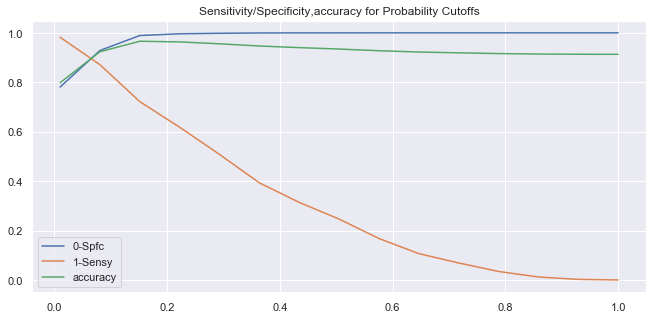

In [772]:
plt.figure(figsize=(11,5))
plt.plot(np.linspace(.01,1,15),sen0,label="0-Spfc")
plt.plot(np.linspace(.01,1,15),sen1,label="1-Sensy")
plt.plot(np.linspace(.01,1,15),accu,label="accuracy")
plt.legend()
plt.title("Sensitivity/Specificity,accuracy for Probability Cutoffs")
plt.show()

In [801]:
confusion_matrix(y_train,rf.predict_proba(X_train)[:,1] > 0.025) # 0.025 cutoff since sinsiti of mimority class needed more
                                                                 # without dropping much specificity and accuracy

array([[16308,  2053],
       [   99,  1647]], dtype=int64)

In [802]:
print(classification_report(y_train,rf.predict_proba(X_train)[:,1] > 0.025))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94     18361
           1       0.45      0.94      0.60      1746

    accuracy                           0.89     20107
   macro avg       0.72      0.92      0.77     20107
weighted avg       0.95      0.89      0.91     20107



In [803]:
confusion_matrix(y_test,rf.predict_proba(X_test)[:,1] > 0.025)

array([[7173, 1884],
       [ 248,  599]], dtype=int64)

In [804]:
print(classification_report(y_test,rf.predict_proba(X_test)[:,1] > 0.025))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      9057
           1       0.24      0.71      0.36       847

    accuracy                           0.78      9904
   macro avg       0.60      0.75      0.62      9904
weighted avg       0.90      0.78      0.83      9904



# Decision Tree

In [810]:
from sklearn.tree import DecisionTreeClassifier

In [814]:
dtree = DecisionTreeClassifier(class_weight={0:.91,1:.09})

In [813]:
#DecisionTreeClassifier(
#    criterion='gini',
#   splitter='best',
#    max_depth=None,
#    min_samples_split=2,
#    min_samples_leaf=1,
#    min_weight_fraction_leaf=0.0,
#    max_features=None,
#    random_state=None,
#    max_leaf_nodes=None,
#    min_impurity_decrease=0.0,
#    min_impurity_split=None,
#    class_weight=None,
#    presort=False,
#)

In [817]:
param_grid1 = {'criterion':["gini","entropy"],'min_samples_split':[2,4,6,8,10,13],"max_depth":[3,4,5,6,7,8,9,10,11],
             "min_samples_leaf":[1,2,3,4,5,6,7]}

In [818]:
grid1 =GridSearchCV(dtree,param_grid,cv=3,scoring="roc_auc",return_train_score=True,n_jobs=-1)

In [819]:
grid1.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight={0: 0.91, 1: 0.09},
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 1

In [820]:
dfvt = pd.DataFrame(grid1.cv_results_)

In [821]:
dfvt[dfvt["mean_train_score"]==dfvt["mean_train_score"].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
748,4.760192,0.164364,0.010063,0.000011,entropy,11,6,10,"{'criterion': 'entropy', 'max_depth': 11, 'min...",0.723008,0.727259,0.69302,0.714429,0.015237,735,0.979965,0.970281,0.983099,0.977782,0.005456


In [822]:
dt = DecisionTreeClassifier(criterion="entropy",class_weight={0:.91,1:.09},max_depth=11,
                            min_samples_leaf=6,min_samples_split=10)

In [823]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight={0: 0.91, 1: 0.09}, criterion='entropy',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [825]:
confusion_matrix(y_test,dt.predict(X_test))

array([[8942,  115],
       [ 689,  158]], dtype=int64)

In [826]:
print(classification_report(y_test,dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9057
           1       0.58      0.19      0.28       847

    accuracy                           0.92      9904
   macro avg       0.75      0.59      0.62      9904
weighted avg       0.90      0.92      0.90      9904



In [829]:
sen0=[]
sen1=[]
accu =[]
for prob in np.linspace(.001,1,15):
    cf = confusion_matrix(y_train,dt.predict_proba(X_train)[:,1]>prob)
    sensitivity0 = cf[0,0]/(cf[0,0]+cf[0,1])
    sensitivity1= cf[1,1]/(cf[1,1]+cf[1,0])
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,1]+cf[1,0])
    sen0.append(sensitivity0)
    sen1.append(sensitivity1)
    accu.append(acc)

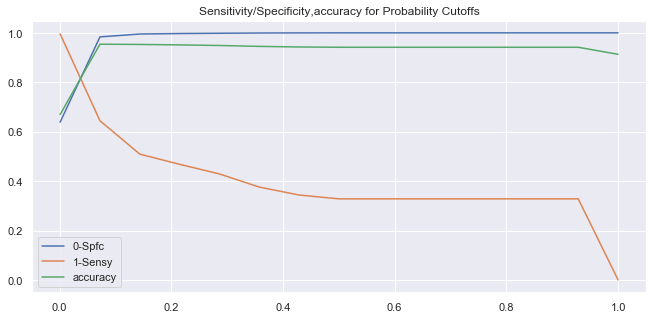

In [830]:
plt.figure(figsize=(11,5))
plt.plot(np.linspace(.001,1,15),sen0,label="0-Spfc")
plt.plot(np.linspace(.001,1,15),sen1,label="1-Sensy")
plt.plot(np.linspace(.001,1,15),accu,label="accuracy")
plt.legend()
plt.title("Sensitivity/Specificity,accuracy for Probability Cutoffs")
plt.show()

In [841]:
confusion_matrix(y_train,dt.predict_proba(X_train)[:,1] > 0.028) # 0.027 cutoff since sinsiti of mimority class needed more
                                                                 # without dropping much specificity and accuracy

array([[17462,   899],
       [  297,  1449]], dtype=int64)

In [842]:
print(classification_report(y_train,dt.predict_proba(X_train)[:,1] > 0.028))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     18361
           1       0.62      0.83      0.71      1746

    accuracy                           0.94     20107
   macro avg       0.80      0.89      0.84     20107
weighted avg       0.95      0.94      0.94     20107



In [843]:
confusion_matrix(y_test,dt.predict_proba(X_test)[:,1] > 0.028)

array([[8337,  720],
       [ 446,  401]], dtype=int64)

In [844]:
print(classification_report(y_test,dt.predict_proba(X_test)[:,1] > 0.028))# Could not set cut off lesser than 0.27
                                                                          #since sensi and specifi both decrease fast 

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      9057
           1       0.36      0.47      0.41       847

    accuracy                           0.88      9904
   macro avg       0.65      0.70      0.67      9904
weighted avg       0.90      0.88      0.89      9904



# Recommendation 

Below Features  with -ve coefficient mean user with increase in these variables overtime are less likely to churn 
---------------------------------
arpu_7              :  0.3439 <br>
onnet_mou_8         : -0.2692 <br>
loc_og_t2m_mou_7    : -0.3362 <br>
std_og_t2m_mou_8    : -0.4090 <br>
vol_2g_mb_8         : -0.4406 <br>
aon                 : -0.4530 <br>
spl_ic_mou_8        : -0.5964 <br>
loc_ic_mou_8        : -0.7173 <br>
vol_3g_mb_8         : -0.7256 <br>
total_rech_num_8    : -0.8811 <br>
last_day_rch_amt_8  : -1.1004 <br>

1# Due to lesser number of class 1/ churn cases model has to care more for sensitivity of class 1 <br>
2# This result in rolling offer to customers who does not seem to churn is a cost due to low precision of model in general <br>
3# But this will pay in long term to retain those customers who model predicts to churn but not churnded in month 9 in fact<br>
   Which is in line with management objective to retain customers since acquiring them is additional cost